# Correlating microstripline model to measurement

## Target

The aim of this example is to correlate the microstripline model to the measurement over 4 frequency decades from 1MHz to 5GHz.

## Plan

1. Two different lengths of microstripline are measured;
2. Multiline method is used to compute the frequency dependent relative permittivity and loss angle of the dielectric;
3. Microstripline model is fitted to the computed parameters by optimization;
4. Checking the results by embedding the connectors and comparison against measurement;

In [1]:
%load_ext autoreload
%autoreload 2
import skrf as rf
import numpy as np
from numpy import real, log10, sum, absolute, pi, sqrt
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution

rf.stylely()

## Measurement of two microstripline with different lengths
The measurement where performed the 21th March 2017 on a Anritsu MS46524B 20GHz Vector Network Analyser. The setup is a linear frequency sweep from 1MHz to 10GHz with 10'000 points. Output power is 0dBm, IF bandwidth is 1kHz and neither averaging nor smoothing are used.

The frequency range of interest is limited from 1MHz to 5GHz, but the measurement are up to 10GHz.

MSLxxx is a L long, W wide, T thick copper microstripline on a H height substrate with bottom ground plane.

| Name | L (mm) | W (mm) | H (mm) | T (um) | Substrate |
| :--- | ---: | ---: | ---: | ---: | :--- |
| MSL100 | 100 | 3.00 | 1.55 | 50 | FR-4 |
| MSL200 | 200 | 3.00 | 1.55 | 50 | FR-4 |

The milling of the artwork is performed mechanically with a lateral wall of 45°. A small top ground plane chunk connected by a vias array to bottom ground is provided to solder the connector top ground legs and provide some coplanar-like transition from coax to microstrip.

The relative permittivity of the dielectric was assumed to be approximately 4.5 for design purpose.

![MSL100 and MSL200 illustration, both are microstripline, MSL200 is twice the length of MSL100](MSL_CPWG_100_200.jpg "MSL100 and MSL200")

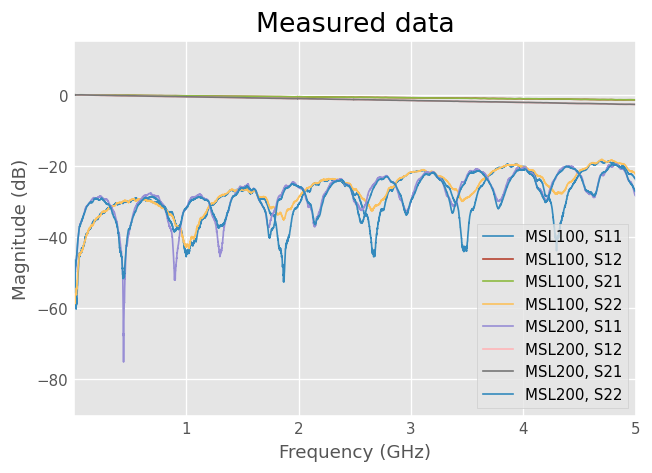

In [2]:
# Load raw measurements
MSL100_raw = rf.Network('MSL100.s2p')
MSL200_raw = rf.Network('MSL200.s2p')

# Keep only the data from 1MHz to 5GHz
MSL100 = MSL100_raw['1-5000mhz']
MSL200 = MSL200_raw['1-5000mhz']

plt.figure()
plt.title('Measured data')
MSL100.plot_s_db()
MSL200.plot_s_db()
plt.show()

The measured data shows that the electrical length of MSL200 is approximately twice the one of MSL100. The frequency spacing between Return Loss dips is approximately the half for MSL200 compared to MSL100. This is coherent with the physical dimensions if the small connector length is neglected.

The MSL200 Insertion Loss is also about twice than MSL100, which is coherent as a longer path bring more attenuation.

Return Loss under -20dB is usually considered to be fair for microstripline, it correspond to 1% of the power being reflected. 

## Dielectric effective relative permittivity extraction by multiline method
The phase of the measurements transmission parameter are subtracted. Because connectors are present on both DUTs, their length effect is canceled and the remaining phase difference is related to the difference of the DUTs length.

Knowing the physical length $\Delta L$ and the phase $\Delta \phi$, the effective relative permittivity constant $\epsilon_{r,eff}$ can be computed from the relation
$$\left\{ \begin{array}{ll}
\lambda = \frac{c_0}{f \cdot \sqrt{\epsilon_{r,eff}}} \\
\phi = \frac{2\pi L}{\lambda}
\end{array} \right. \implies
\epsilon_{r,eff} = \left( \frac{\Delta \phi \cdot c_0}{2 \pi f \cdot \Delta L} \right)^2 $$

In the same idea, the difference of Insertion Loss of the two DUT gives the Insertion Loss of the difference of the length and cancel connectors effects.

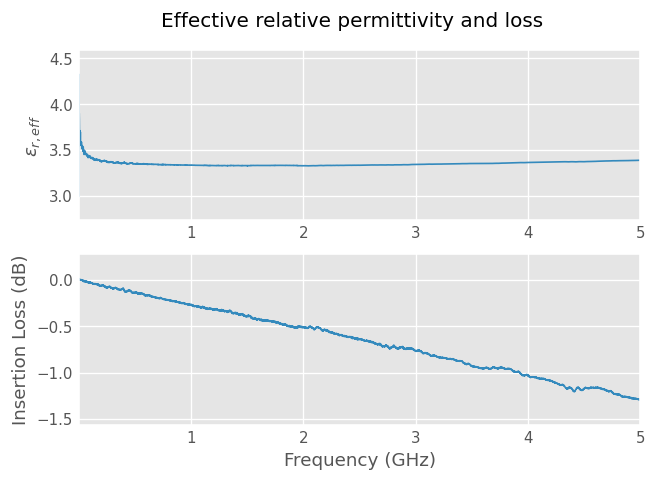

In [3]:
c0       = 3e8
f        = MSL100.f
deltaL   = 0.1
deltaPhi = np.unwrap(np.angle(MSL100.s[:,1,0])) - np.unwrap(np.angle(MSL200.s[:,1,0]))
Er_eff   = np.power(deltaPhi * c0 / (2 * np.pi * f * deltaL), 2)
Loss_mea = 20 * log10(absolute(MSL200.s[:,1,0] / MSL100.s[:,1,0]))

plt.figure()
plt.suptitle('Effective relative permittivity and loss')
plt.subplot(2,1,1)
plt.plot(f * 1e-9, Er_eff)
plt.ylabel('$\epsilon_{r,eff}$')

plt.subplot(2,1,2)
plt.plot(f * 1e-9, Loss_mea)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Insertion Loss (dB)')
plt.show()

The effective relative permittivity of the geometry shows a dispersion effect at low frequency which can be modelled by a wideband Debye model such as *Djordjevic/Svensson* implementation of skrf microstripline media. The value then increase slowly with frequency which correspond roughly to the *Kirschning and Jansen* dispersion model.

The Insertion Loss seems proportional to frequency, which indicate a predominance of the dielectric losses. Conductor losses are related to the square-root of frequency. Radiation losses are neglected.

## Fit microstripline model to the computed parameters by optimization

### Effective relative permittivity
Microstrip media model with the physical dimensions of the measured microstriplines is fitted to the computed $\epsilon_{r,eff}$ by optimization of $\epsilon_r$ and tand of the substrate at 1GHz. The dispersion model used to account for frequency variation of the parameters are *Djordjevic/Svensson* and *Kirschning and Jansen*.

In [21]:
from skrf.media import MLine

W   = 3.00e-3
H   = 1.55e-3
T   = 50e-6
L   = 0.1
Er0   = 4.5
tand0 = 0.02
f_epr_tand = 1e9
x0 = [Er0, tand0]

def model(x, freq, Er_eff, L, W, H, T, f_epr_tand, Loss_mea):
    ep_r = x[0]
    tand = x[1]
    m = MLine(frequency=freq, z0=50, w=W, h=H, t=T,
        ep_r=ep_r, mu_r=1, rho=1.712e-8, tand=tand, rough=0.15e-6,
        f_low=1e3, f_high=1e12, f_epr_tand=f_epr_tand,
        diel='djordjevicsvensson', disp='kirschningjansen')
    DUT  = m.line(L, 'm', embed=True, z0=m.Z0)
    Loss_mod = 20 * log10(absolute(DUT.s[:,1,0]))
    return sum((real(m.ep_reff_f) - Er_eff)**2) + 0.01*sum((Loss_mod - Loss_mea)**2)

res = minimize(model, x0, args=(MSL100.frequency, Er_eff, L, W, H, T, f_epr_tand, Loss_mea),
               bounds=[(4.2, 4.7), (0.001, 0.1)])
Er   = res.x[0]
tand = res.x[1]

print('Er={:.3f}, tand={:.4f} at {:.1f} GHz.'.format(Er, tand, f_epr_tand * 1e-9))

C:\Users\huser\SynologyDrive\prj\048-scikit-rf\scikit-rf\skrf\media\mline.py:329: RuntimeWarning: Conductor loss calculation invalid for lineheight t (5e-05)  < 3 * skin depth (6.585246128681408e-05)
  warnings.warn(


Er=4.425, tand=0.0169 at 1.0 GHz.


As a sanity check, the model data are compared with the computed parameters

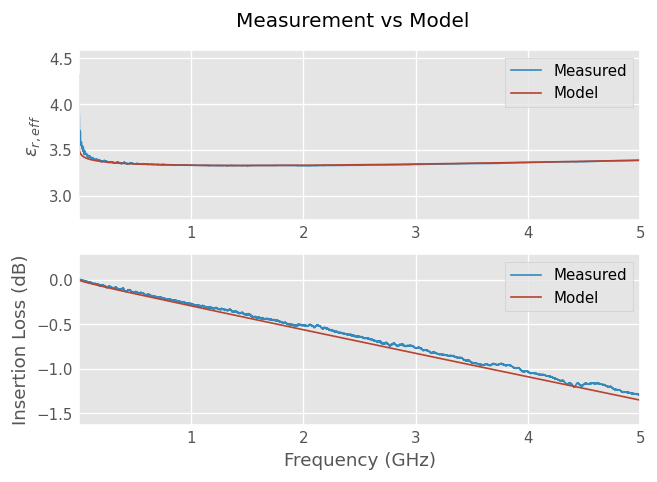

In [22]:
m = MLine(frequency=MSL100.frequency, z0=50, w=W, h=H, t=T,
        ep_r=Er, mu_r=1, rho=1.712e-8, tand=tand, rough=0.15e-6,
        f_low=1e3, f_high=1e12, f_epr_tand=f_epr_tand,
        diel='djordjevicsvensson', disp='kirschningjansen')
DUT  = m.line(L, 'm', embed=True, z0=m.Z0)
DUT.name = 'DUT'
Loss_mod = 20 * log10(absolute(DUT.s[:,1,0]))

plt.figure()
plt.suptitle('Measurement vs Model')
plt.subplot(2,1,1)
plt.plot(f * 1e-9, Er_eff, label='Measured')
plt.plot(f * 1e-9, real(m.ep_reff_f), label='Model')
plt.ylabel('$\epsilon_{r,eff}$')
plt.legend()

plt.subplot(2,1,2)
plt.plot(f * 1e-9, Loss_mea, label='Measured')
plt.plot(f * 1e-9, Loss_mod, label='Model')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Insertion Loss (dB)')
plt.legend()
plt.show()

The model results shows a reasonable agreement with the measured $\epsilon_{r,eff}$ and Insertion Loss values.

## Checking the results

If the model is now plotted against the measurement of the same length, the plot shows no agreement. This is because the connector effects are not captured by the model.

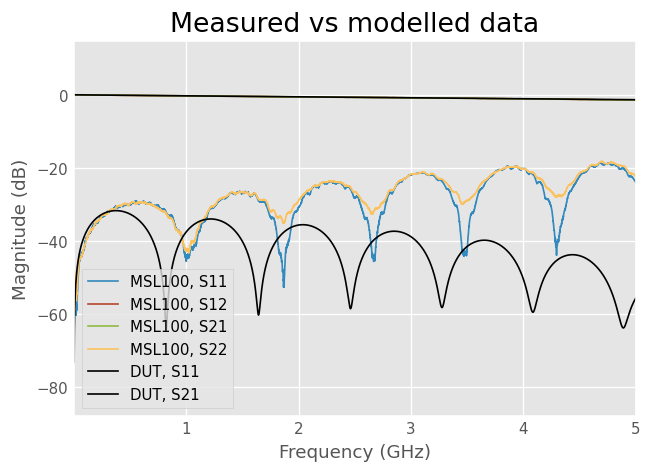

In [23]:
plt.figure()
plt.title('Measured vs modelled data')
MSL100.plot_s_db()
DUT.plot_s_db(0, 0, color='k')
DUT.plot_s_db(1, 0, color='k')
plt.show()


### Connector delay and loss estimation

The delay of the connector is estimated by fitting a line to its phase contribution vs frequency.

The phase and loss of the two connector are computed by subtracting phase and loss computed without the connectors to the measurement of the same length.

Connector delay: 39 ps


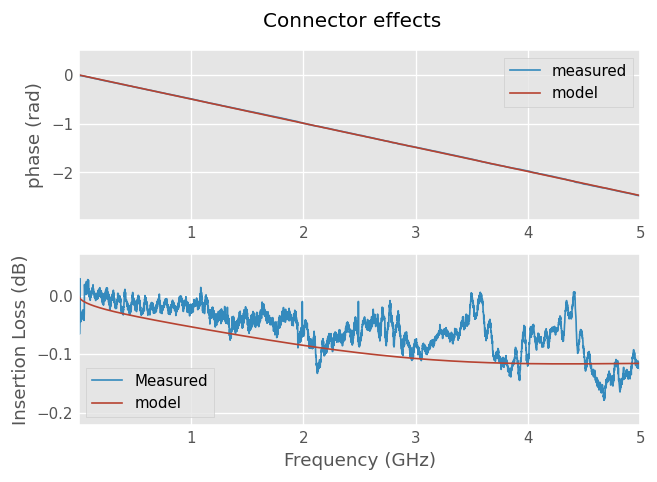

In [34]:
phi_conn = np.unwrap(np.angle(MSL100.s[:,1,0])) + deltaPhi
z = np.polyfit(f, phi_conn, 1)
p = np.poly1d(z)
delay = -z[0]/(2*np.pi)/2
print('Connector delay: {:.0f} ps'.format(delay * 1e12))

loss_conn_db = 20 * log10(absolute(MSL100.s[:,1,0])) - Loss_mea
alpha = 1.6*np.log(10)/20 * np.sqrt(f/1e9)
beta  = 2*np.pi*f/c0
gamma = alpha + 1j*beta
mf = rf.media.DefinedGammaZ0(m.frequency, z0=50, gamma=gamma)
left = mf.line(delay*1e9, 'ns', embed=True, z0=54)
right = left.flipped()
check = left ** right

plt.figure()
plt.suptitle('Connector effects')
plt.subplot(2,1,1)
plt.plot(f * 1e-9, phi_conn, label='measured')
plt.plot(f * 1e-9, np.unwrap(np.angle(check.s[:,1,0])), label='model')
plt.ylabel('phase (rad)')
plt.legend()

plt.subplot(2,1,2)
plt.plot(f * 1e-9, loss_conn_db, label='Measured')
plt.plot(f * 1e-9, 20*np.log10(np.absolute(check.s[:,1,0])), label='model')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Insertion Loss (dB)')
plt.legend()
plt.show()

The phase of the model shows a good agreement, while the Insertion Loss seems to have a reasonable agreement and is small whatsoever.

### Connector impedance adjustment by time-domain reflectometry

Time-domain step responses of  measurement and model are used to adjust the connector model characteristic impedance.

The plots shows the connector having an inductive behaviour (positive peak) and the microstripline being a bit too much capacitive (negative plateau).

Characteristic impedance of the connector is tuned by trial-and-error until a reasonable agreement is achieved. Optimization could have been used instead.



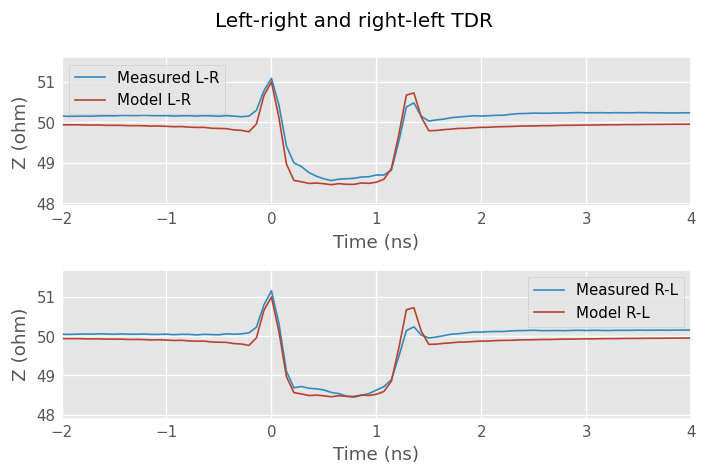

In [35]:
mod = left ** DUT ** right

MSL100_dc = MSL100.extrapolate_to_dc(kind='linear')
DUT_dc = mod.extrapolate_to_dc(kind='linear')

plt.figure()
plt.suptitle('Left-right and right-left TDR')
plt.subplot(2,1,1)
MSL100_dc.s11.plot_z_time_step(pad=2000, window='hamming', label='Measured L-R')
DUT_dc.s11.plot_z_time_step(pad=2000, window='hamming', label='Model L-R')
plt.xlim(-2, 4)

plt.subplot(2,1,2)
MSL100_dc.s22.plot_z_time_step(pad=2000, window='hamming', label='Measured R-L')
DUT_dc.s22.plot_z_time_step(pad=2000, window='hamming', label='Model R-L')
plt.xlim(-2, 4)

plt.tight_layout()
plt.show()

### Final comparison

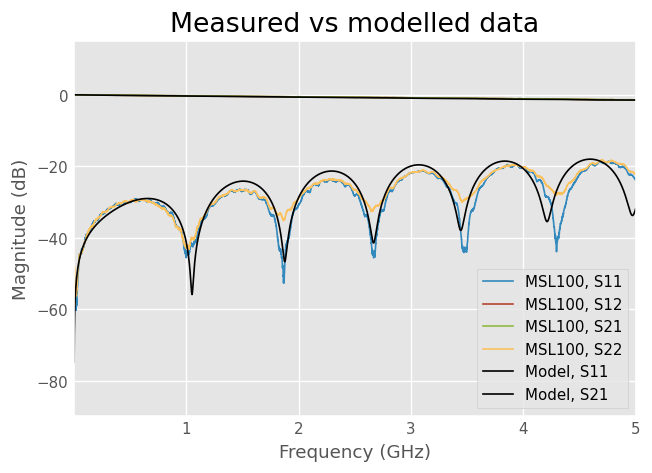

In [36]:
plt.figure()
plt.title('Measured vs modelled data')
MSL100.plot_s_db()
mod.name = 'Model'
mod.plot_s_db(0, 0, color='k')
mod.plot_s_db(1, 0, color='k')

plt.show()

The plot shows a decent agreement between the model and the measured data. The model is a good representation of the DUT between 1MHz and 5 GHz.

At higher frequency, the model begin to deviate from the measurement. The model does not capture effects such as radiation loss or complex copper roughness. Smaller geometries such as the top ground plane chunk may also begin to contribute as they become electrically long with the increase of frequency.

As a comparison, the 5GHz wavelength is 60mm in the air and the MSL100 line is 100mm long. The DUT itself is electrically long above some GHz.
